<a href="https://colab.research.google.com/github/M4mbo/PPO_Clip_for_LunarLander/blob/main/PPO_Lunar_Lander_Discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the lander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## PPO

PPO is motivated by the same question as TRPO: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? Where TRPO tries to solve this problem with a complex second-order method, PPO is a family of first-order methods that use a few other tricks to keep new policies close to old. PPO methods are significantly simpler to implement, and empirically seem to perform at least as well as TRPO.

There are two primary variants of PPO: PPO-Penalty and PPO-Clip.

**PPO-Penalty** approximately solves a KL-constrained update like TRPO, but penalizes the KL-divergence in the objective function instead of making it a hard constraint, and automatically adjusts the penalty coefficient over the course of training so that it's scaled appropriately.

**PPO-Clip** doesn't have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.

Read more [here](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

Here, we'll focus only on PPO-Clip.

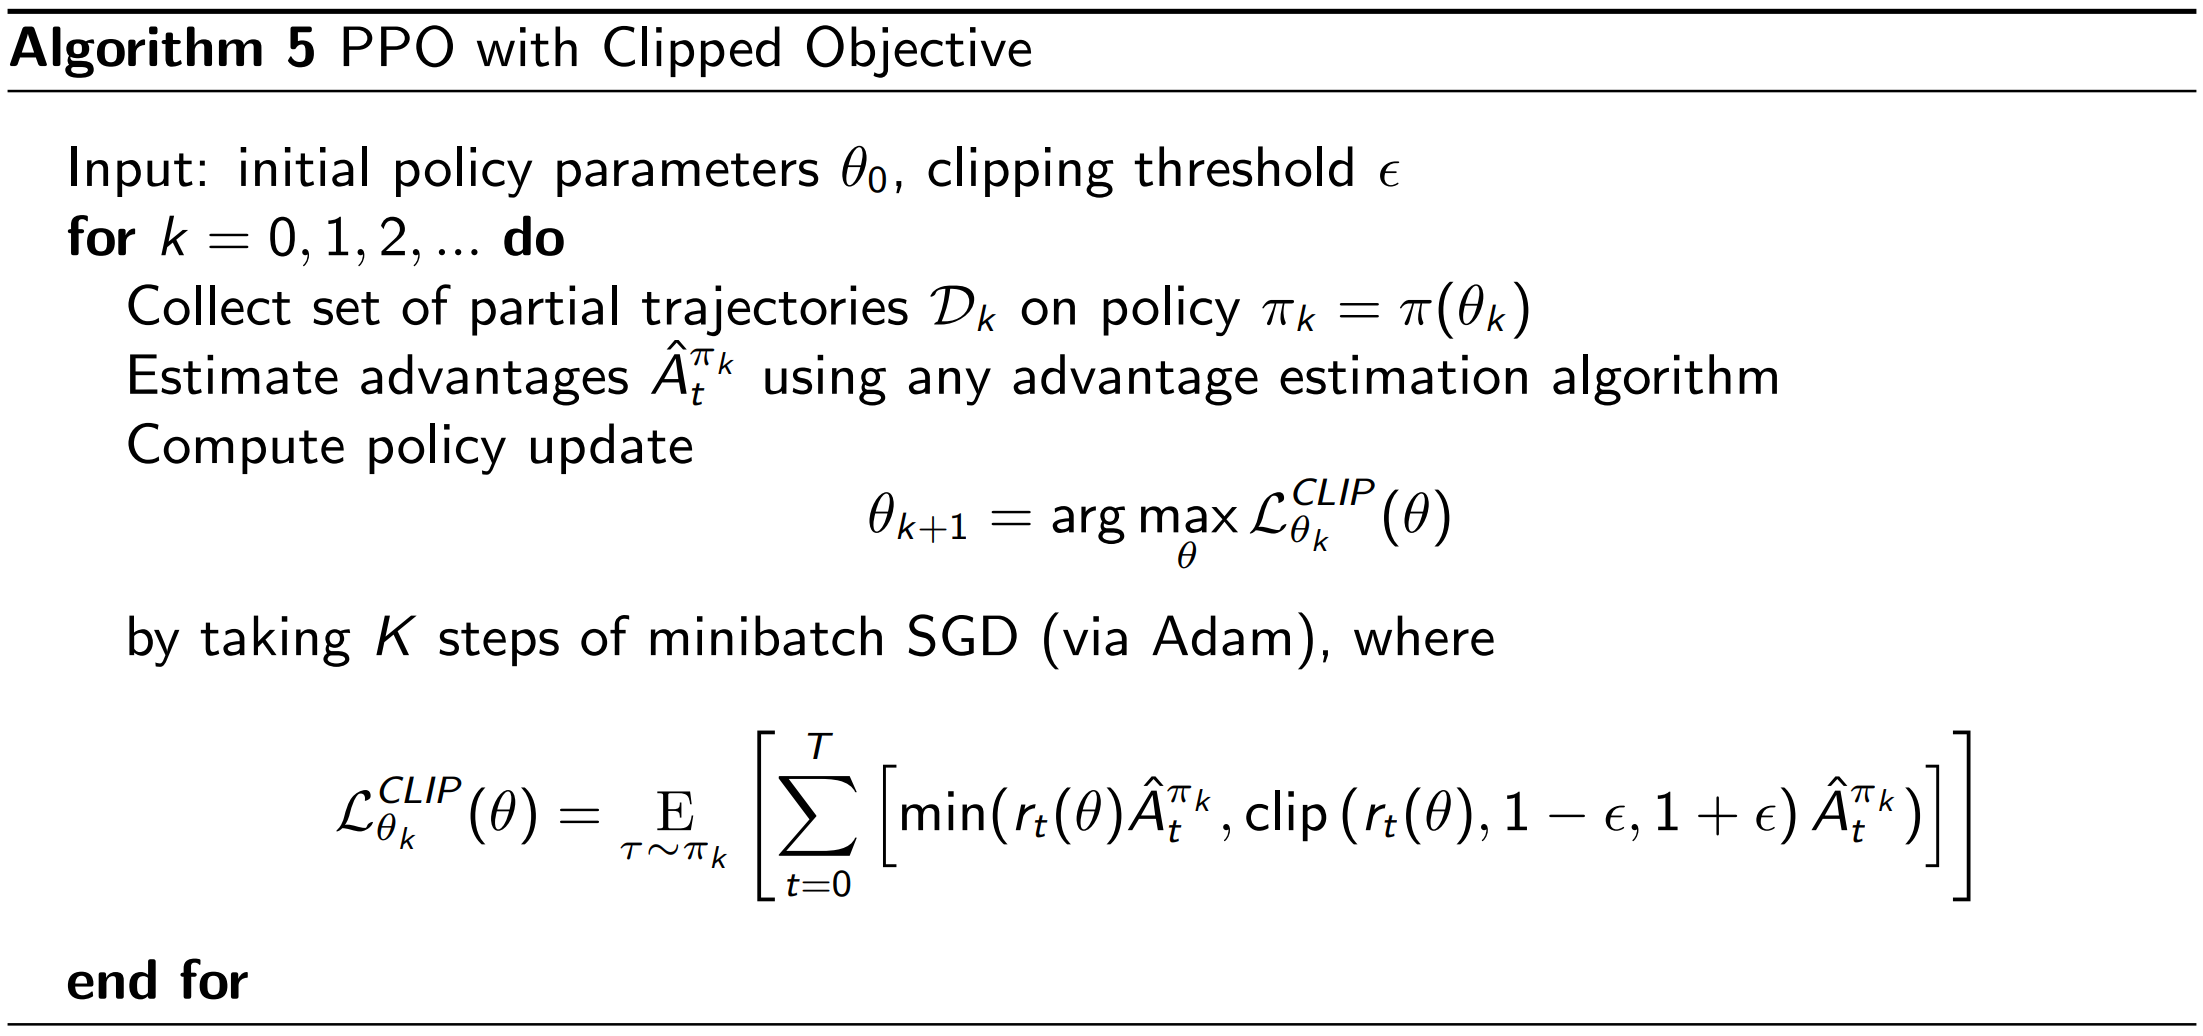

In [174]:
!pip install -q swig
!pip install -q gym[box2d]

In [175]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [176]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [177]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [178]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print('state size:', state_dim)
print('action size:', action_dim)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [179]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

        # Initialize weights
        for layer in self.actor:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        probs = F.softmax(self.actor(x), dim=-1)
        return probs

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
          probs = self.forward(state)

        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action, log_prob

    def evaluate(self, state, action):
      """
      Evaluate state action according to current policy
      """
      probs = self.forward(state)

      m = Categorical(probs)

      action_logprobs = m.log_prob(action)
      dist_entropy = m.entropy()

      return action_logprobs, dist_entropy

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

        # Initialize weights
        for layer in self.critic:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        return self.critic(x)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state_value = self.forward(state)
        return state_value.squeeze(0)

    def evaluate(self, state):
      """
      Evaluate state action according to current policy
      """
      state_value = self.forward(state)
      return state_value


In [180]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 300              # Max steps per episode
learning_rate_a = 1e-3        # Learning rate for the actor
learning_rate_c = 2e-3        # Learning rate for the critic
gamma = 0.99                 # Discounting rate
train_freq = 3               # update policy every n timesteps
K_epochs = 10                # update policy for K epochs
eps_clip = 0.2               # clip parameter for PPO

In [181]:
actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim, action_dim).to(device)

optimizer_a = optim.Adam(actor.parameters(), lr=learning_rate_a)
optimizer_c = optim.Adam(critic.parameters(), lr=learning_rate_c)


In [182]:
# Buffer to store trajectories
class RolloutBuffer:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.state_values = []
    self.is_terminals = []

  def clear(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.state_values[:]
    del self.is_terminals[:]

In [183]:
def trainAC(actor, critic, optim_a, optim_c, total_episodes, max_steps, gamma, device):
  scores = []
  buffer = RolloutBuffer()
  timesteps = 0
  for episode in range(1, total_episodes+1):
    reached_goal = False
    saved_log_probs = []
    rewards = []
    saved_buffer = {'log_prob':[], 'value':[]}
    state = env.reset()
    # collect trajectory
    for t in range(max_steps):
      prev_state = state
      # sample action and its log probability from policy
      action, log_prob = actor.act(state)
      value = critic.act(state)
      state, reward, done, _ = env.step(action.item())

      # Saving in buffer
      buffer.states.append(torch.FloatTensor(state).to(device))
      buffer.actions.append(action)
      buffer.logprobs.append(log_prob)
      buffer.state_values.append(value)
      buffer.rewards.append(reward)
      buffer.is_terminals.append(done)

      rewards.append(reward)
      # check if the goal has been reached

      if done:
        break

    scores.append(sum(rewards))

    if reward >= 200:
        reached_goal = True

    if episode % train_freq == 0:
      # Compute the discounted returns at each timestep
      returns = []
      discounted_reward = 0
      for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.is_terminals)):
        if is_terminal:
          discounted_reward = 0
        discounted_reward = reward + (gamma * discounted_reward)
        returns.insert(0, discounted_reward)

      # Normalizing the returns
      returns = torch.tensor(returns, dtype=torch.float32).to(device)
      returns = (returns - returns.mean()) / (returns.std() + 1e-7)

      # convert list to tensor
      old_states = torch.squeeze(torch.stack(buffer.states, dim=0)).detach().to(device)
      old_actions = torch.squeeze(torch.stack(buffer.actions, dim=0)).detach().to(device)
      old_logprobs = torch.squeeze(torch.stack(buffer.logprobs, dim=0)).detach().to(device)
      old_state_values = torch.squeeze(torch.stack(buffer.state_values, dim=0)).detach().to(device)

      # calculate advantages
      advantages = returns.detach() - old_state_values.detach()

      # Optimize policy for K epochs
      for _ in range(K_epochs):
        # Evaluating old actions and values
        logprobs, dist_entropy = actor.evaluate(old_states, old_actions)
        state_values = critic.evaluate(old_states)
        # match state_values tensor dimensions with returns tensor
        state_values = torch.squeeze(state_values)

        # Finding the ratio (pi_theta / pi_theta__old)
        ratios = torch.exp(logprobs - old_logprobs.detach())

        # Finding Surrogate Loss
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1-eps_clip, 1+eps_clip) * advantages

        # final loss of clipped objective PPO
        loss = -torch.min(surr1, surr2) + 0.5 * F.smooth_l1_loss(state_values, returns) - 0.01 * dist_entropy

        # take gradient step
        optimizer_a.zero_grad()
        optimizer_c.zero_grad()
        loss.mean().backward()
        optimizer_a.step()
        optimizer_c.step()


      # clear buffer
      buffer.clear()

    print(f"Episode {episode}: Reward = {scores[-1]}, Reached Goal: {reached_goal}")

    timesteps = timesteps + 1

  return scores



In [184]:
scores = trainAC(actor, critic, optimizer_a, optimizer_c, total_episodes, max_steps, gamma, device)

Episode 1: Reward = -88.9499656405917, Reached Goal: False
Episode 2: Reward = -362.1731072207166, Reached Goal: False
Episode 3: Reward = -86.19694236933789, Reached Goal: False
Episode 4: Reward = -190.10708116140376, Reached Goal: False
Episode 5: Reward = -127.37538776061776, Reached Goal: False
Episode 6: Reward = -130.29452278378704, Reached Goal: False
Episode 7: Reward = -181.08433589961254, Reached Goal: False
Episode 8: Reward = -131.8830411517343, Reached Goal: False
Episode 9: Reward = -116.58304221678256, Reached Goal: False
Episode 10: Reward = -7.845710501036493, Reached Goal: False
Episode 11: Reward = -90.39078024192062, Reached Goal: False
Episode 12: Reward = -278.0474018067465, Reached Goal: False
Episode 13: Reward = -106.91968975519609, Reached Goal: False
Episode 14: Reward = -122.01018569024654, Reached Goal: False
Episode 15: Reward = -120.65090865482657, Reached Goal: False
Episode 16: Reward = -102.73419618708876, Reached Goal: False
Episode 17: Reward = -166

Text(0, 0.5, 'Reward')

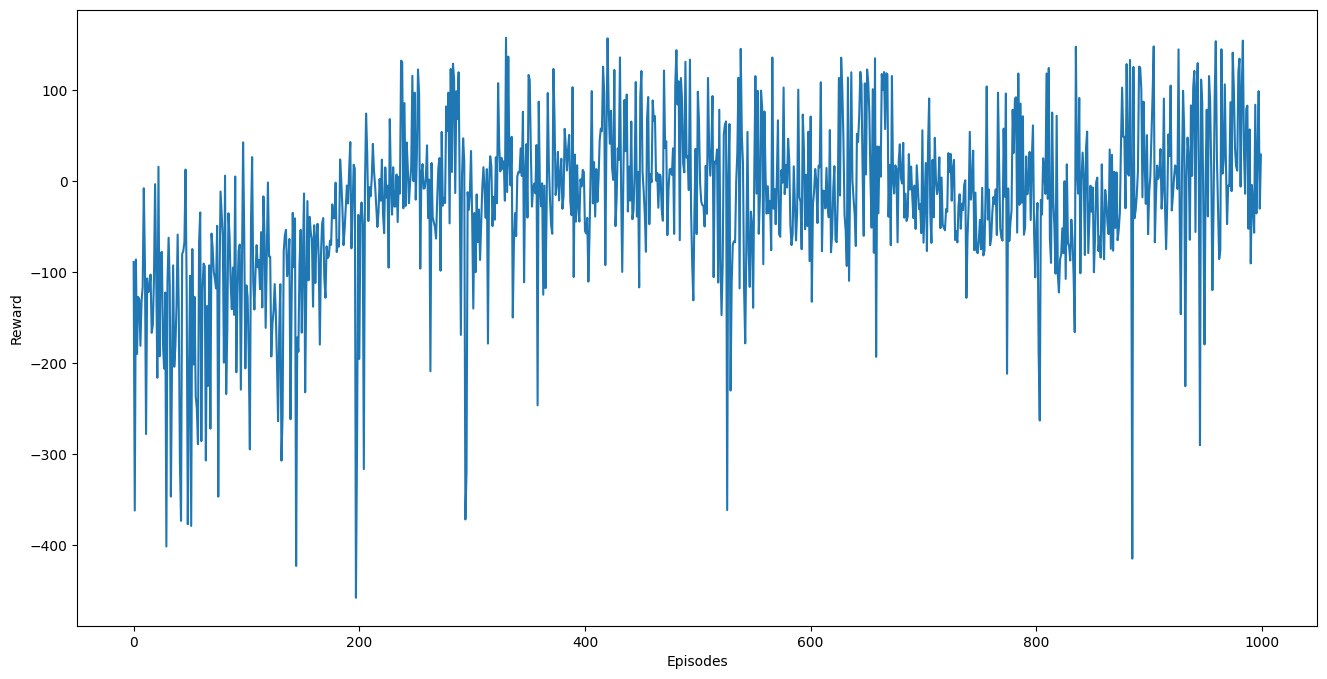

In [185]:
plt.figure(figsize=(16,8))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

In [186]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [187]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _ = actor.act(state)
        next_state, reward, done, info = env.step(action.item())
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [188]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [189]:
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
